In [47]:
from pathlib import Path
import sys
import pandas as pd
import seaborn as sns
import re
import html
import matplotlib.pyplot as plt

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

from src.load_data import load_review, load_meta
from collections import Counter
from src.preprocessing import filter_users_items, time_split, expand_dict_column, expand_video_games_rank
from ml_utils.eda import basic_overview

In [2]:
df = load_review()
df = df.drop("image", axis=1) # add to load script

# Overview

In [3]:
basic_overview(df)

Shape: (2565349, 11)

Info:
<class 'pandas.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 11 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   overall         int64 
 1   verified        bool  
 2   reviewTime      str   
 3   reviewerID      str   
 4   asin            str   
 5   reviewerName    str   
 6   reviewText      str   
 7   summary         str   
 8   unixReviewTime  int64 
 9   vote            str   
 10  style           object
dtypes: bool(1), int64(2), object(1), str(7)
memory usage: 198.2+ MB
None

Missing values:
overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName          253
reviewText           1715
summary               811
unixReviewTime          0
vote              2122633
style             1245377
dtype: int64

Describe:
            overall  unixReviewTime
count  2.565349e+06    2.565349e+06
mean   4.022095e+00    1.388666e+

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style
0,1,True,"06 9, 2014",A21ROB4YDOZA5P,0439381673,Mary M. Clark,I used to play this game years ago and loved i...,Did not like this,1402272000,NaN,NaN
1,3,True,"05 10, 2014",A3TNZ2Q5E7HTHD,0439381673,Sarabatya,The game itself worked great but the story lin...,Almost Perfect,1399680000,NaN,NaN
2,4,True,"02 7, 2014",A1OKRM3QFEATQO,0439381673,Amazon Customer,I had to learn the hard way after ordering thi...,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,1391731200,15,NaN
3,1,True,"02 7, 2014",A2XO1JFCNEYV3T,0439381673,ColoradoPartyof5,The product description should state this clea...,does not work on Mac OSX,1391731200,11,NaN
4,4,True,"01 16, 2014",A19WLPIRHD15TH,0439381673,Karen Robinson,I would recommend this learning game for anyon...,Roughing it,1389830400,NaN,NaN


In [5]:
n_users = df.reviewerID.nunique()
n_items = df.asin.nunique()

avg_interactions_per_user = len(df) / n_users
avg_interactions_per_item = len(df) / n_items


print(f"Users: {n_users}")
print(f"Items: {n_items}")
print(f"Interactions: {len(df)}")
print(f"Average interactions per user: {avg_interactions_per_user:.2f}")
print(f"Average interactions per item: {avg_interactions_per_item:.2f}")

Users: 1540618
Items: 71982
Interactions: 2565349
Average interactions per user: 1.67
Average interactions per item: 35.64


For this recommendation system, only users and items with more than 10 reviews will be included.

In [6]:
user_counts = df.groupby('reviewerID')['asin'].count()
(user_counts).describe()

count    1.540618e+06
mean     1.665143e+00
std      2.892944e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      8.880000e+02
Name: asin, dtype: float64

In [7]:
df.duplicated(["reviewerID", "asin", "reviewTime"]).sum()

np.int64(75256)

After inspecting the dataset, I found ~75k exact duplicates. For simplicity and to focus on the latest user-item interactions, I will keep only the most recent review per user-item. So remaining data will have unique reviewer-item pairs suitable for collaborative filtering.

In [8]:
df["style"].apply(type).value_counts()

style
<class 'dict'>     1319972
<class 'float'>    1245377
Name: count, dtype: int64

In [9]:
df["style"].isna().mean()

np.float64(0.48546104253261446)

In [10]:
df["style"].dropna().apply(lambda x: list(x.keys())).explode().value_counts()

style
Format:                   515224
Platform:                 435925
Edition:                  293391
Color:                    204839
Style:                     89961
Size:                      41535
Length:                    12769
Subscription Length:       12239
Package Type:               9410
Package Quantity:           3718
Pattern:                    1996
Platform for Display:       1852
Style Name:                 1749
Configuration:              1499
Denomination:                744
Item Package Quantity:       578
Content:                     432
Color Name:                  304
Offer Type:                   84
Size Name:                     5
Name: count, dtype: int64

In [11]:
expanded_df = expand_dict_column(df, 'style')
print("Shape:", expanded_df.shape)
print(expanded_df.head())

Shape: (2565349, 30)
   overall  verified   reviewTime      reviewerID        asin  \
0        1      True   06 9, 2014  A21ROB4YDOZA5P  0439381673   
1        3      True  05 10, 2014  A3TNZ2Q5E7HTHD  0439381673   
2        4      True   02 7, 2014  A1OKRM3QFEATQO  0439381673   
3        1      True   02 7, 2014  A2XO1JFCNEYV3T  0439381673   
4        4      True  01 16, 2014  A19WLPIRHD15TH  0439381673   

       reviewerName                                         reviewText  \
0     Mary M. Clark  I used to play this game years ago and loved i...   
1         Sarabatya  The game itself worked great but the story lin...   
2   Amazon Customer  I had to learn the hard way after ordering thi...   
3  ColoradoPartyof5  The product description should state this clea...   
4    Karen Robinson  I would recommend this learning game for anyon...   

                                             summary  unixReviewTime vote  \
0                                  Did not like this      14022720

In [12]:
expanded_df.isna().sum()

overall                         0
verified                        0
reviewTime                      0
reviewerID                      0
asin                            0
reviewerName                  253
reviewText                   1715
summary                       811
unixReviewTime                  0
vote                      2122633
Style Name:               2563600
Denomination:             2564605
Edition:                  2271958
Package Type:             2555939
Item Package Quantity:    2564771
Pattern:                  2563353
Platform for Display:     2563497
Style:                    2475388
Format:                   2050125
Size:                     2523814
Offer Type:               2565265
Size Name:                2565344
Content:                  2564917
Package Quantity:         2561631
Configuration:            2563850
Subscription Length:      2553110
Platform:                 2129424
Length:                   2552580
Color:                    2360510
Color Name:   

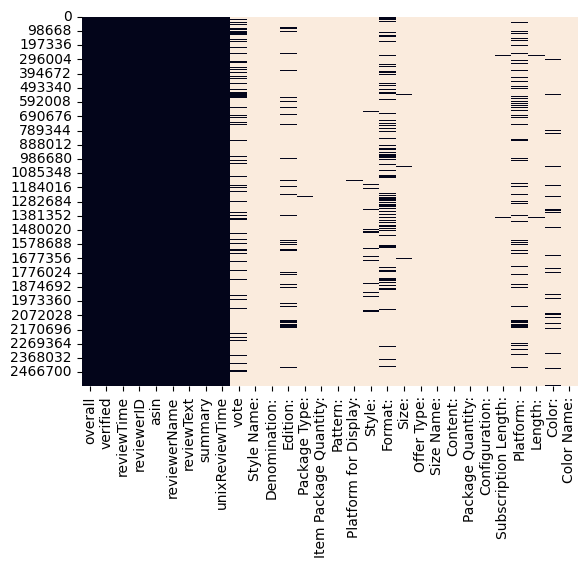

In [13]:
sns.heatmap(expanded_df.isna(), cbar=False)
plt.show()

I'll remove low-frequency columns for simplicity. In a production-level implementation, these could be consolidated into a single "Other" category to retain information while reducing dimensionality.

In [14]:
df = df.drop("style", axis=1)
df["reviewTime"] = pd.to_datetime(df["reviewTime"]) 

In [15]:
df.isna().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName          253
reviewText           1715
summary               811
unixReviewTime          0
vote              2122633
dtype: int64

The vote column can be aggregated with votes from other items, or we can create a new column showing the overall votes for each item.

In [16]:
exact_duplicates = df.duplicated()
print(f"Number of exact duplicates: {exact_duplicates.sum()}")

subset_duplicates = df.duplicated(['reviewerID', 'asin', 'overall'])
print(f"Number of duplicates (same reviewer, product, rating): {subset_duplicates.sum()}")

Number of exact duplicates: 74363
Number of duplicates (same reviewer, product, rating): 75683


In [17]:
review_counts = df.groupby(['reviewerID', 'asin']).agg(
    review_count=('reviewTime', 'count'),
    review_times=('reviewTime', list),
    ratings=('overall', list)
).reset_index()

multiple_reviews = review_counts[review_counts['review_count'] > 1]

different_ratings = multiple_reviews[multiple_reviews['ratings'].apply(lambda x: len(set(x)) > 1)]

different_ratings

,reviewerID,asin,review_count,review_times,ratings
4392,A1067C2BR2F2SX,B000P46NMA,2,"[2015-07-13 00:00:00, 2013-04-05 00:00:00]","[3, 4]"
4695,A106UDIF2Z2ZBG,B000058A56,2,"[2001-12-25 00:00:00, 2001-12-24 00:00:00]","[1, 5]"
30773,A11LS12ZU93SV6,B000035Y3N,2,"[2008-11-28 00:00:00, 2002-09-17 00:00:00]","[4, 3]"
31071,A11MCXXFIVBTWW,B00N4ABT1C,2,"[2014-11-21 00:00:00, 2014-11-21 00:00:00]","[4, 5]"
75004,A13ZUQCGAVA3HM,B01FXROPG4,2,"[2018-06-25 00:00:00, 2017-04-17 00:00:00]","[3, 5]"
...,...,...,...,...,...
2403770,AVB96V97JZFWK,B00AAS888S,2,"[2016-04-30 00:00:00, 2016-03-14 00:00:00]","[5, 4]"
2444099,AXIM8AY6T2PFQ,B000A3IA0Y,2,"[2012-08-27 00:00:00, 2010-12-09 00:00:00]","[2, 5]"
2448586,AXRHGBZV5U08I,B00AOIRCI6,2,"[2014-06-25 00:00:00, 2014-06-11 00:00:00]","[4, 5]"
2449098,AXSEW87EERRPW,B00EZPCX1A,2,"[2015-03-04 00:00:00, 2015-03-04 00:00:00]","[5, 4]"


I'll Keep only the latest rating per user-product to reflect current preferences.

In [93]:
meta = load_meta()
basic_overview(meta)

Shape: (84819, 19)

Info:
<class 'pandas.DataFrame'>
RangeIndex: 84819 entries, 0 to 84818
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         84819 non-null  object
 1   tech1            84819 non-null  str   
 2   description      84819 non-null  object
 3   fit              84819 non-null  str   
 4   title            84819 non-null  str   
 5   also_buy         84819 non-null  object
 6   tech2            84819 non-null  str   
 7   brand            84819 non-null  str   
 8   feature          84819 non-null  object
 9   rank             84819 non-null  object
 10  also_view        84819 non-null  object
 11  main_cat         84819 non-null  str   
 12  similar_item     84819 non-null  str   
 13  date             84819 non-null  str   
 14  price            84819 non-null  str   
 15  asin             84819 non-null  str   
 16  imageURL         84819 non-null  object
 17  imageURLHighRes 

In [95]:
meta.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",0078764343,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Video Games, Retro Gaming & Microconsoles, Su...",,[],,street fighter 2 II turbo super nintendo snes ...,[],,Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,,$0.72,0276425316,[],[],NaN
3,"[Video Games, Xbox 360, Accessories, Controlle...",,[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,,Xbox 360 MAS STICK,[],,by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,,,0324411812,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,"[Video Games, PC, Games, </span></span></span>...",,"[Phonics Alive! 3, The Speller teaches student...",,Phonics Alive! 3: The Speller,[],,by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,,,0439335310,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [96]:
meta["rank"].apply(type).value_counts()

rank
<class 'list'>    84287
<class 'str'>       532
Name: count, dtype: int64

In [97]:
for i, x in enumerate(meta["rank"].head(5)):
    print(i, type(x), x)

0 <class 'list'> ['>#2,623,937 in Toys &amp; Games (See Top 100 in Toys &amp; Games)', '>#39,015 in Video Games &gt; PC Games']
1 <class 'list'> ['>#67,231 in Video Games (See Top 100 in Video Games)', '>#2,279 in Video Games &gt; Xbox 360 &gt; Games']
2 <class 'list'> ['>#134,433 in Video Games (See Top 100 in Video Games)', '>#1,014 in Video Games > More Systems > Super Nintendo > Games']
3 <class 'list'> ['>#105,263 in Video Games (See Top 100 in Video Games)', '>#56 in Video Games &gt; Xbox 360 &gt; Accessories &gt; Controllers &gt; Joysticks', '>#70,640 in Video Games &gt; Accessories']
4 <class 'list'> ['>#92,397 in Video Games (See Top 100 in Video Games)', '>#1,280 in Video Games &gt; Mac Games &gt; Mac Games', '>#11,797 in Video Games &gt; PC Games &gt; PC Games']


In [101]:
expanded_meta = expand_video_games_rank(meta, "rank", "game_rank")
print(expanded_meta.shape)
expanded_meta.head()

(84819, 20)


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details,game_rank
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,39015.0
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",0078764343,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,67231.0
2,"[Video Games, Retro Gaming & Microconsoles, Su...",,[],,street fighter 2 II turbo super nintendo snes ...,[],,Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,,$0.72,0276425316,[],[],NaN,134433.0
3,"[Video Games, Xbox 360, Accessories, Controlle...",,[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,,Xbox 360 MAS STICK,[],,by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,,,0324411812,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,105263.0
4,"[Video Games, PC, Games, </span></span></span>...",,"[Phonics Alive! 3, The Speller teaches student...",,Phonics Alive! 3: The Speller,[],,by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,,,0439335310,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,92397.0


In [102]:
expanded_meta.isna().sum()

category              0
tech1                 0
description           0
fit                   0
title                 0
also_buy              0
tech2                 0
brand                 0
feature               0
rank                  0
also_view             0
main_cat              0
similar_item          0
date                  0
price                 0
asin                  0
imageURL              0
imageURLHighRes       0
details             107
game_rank          5083
dtype: int64

# Preporation

- drop columns: ["image", "style"]
- from meta data keep titel, brand, game_rank (not rank)

reviews summary:
- separate verified and unverified as features for overall asin score
- fix column "reviewTime" and set type datetime.
- column "reviewerID" have huge amount of duplicates paired with asin,
  remove duplicates. keep sum of votes as a new feature.
  add condition if duplicates paired "reviwerID", "asin"
  keep "overall" by "reviewTime" and unique by "reviewerID", "asin" pair.
- handle missing values from reviewerName with reviewerID if Names needed
- set type "vote" to int where NaN = 0
- expend column "style" type dict. Contains missing values.

## Cleaning

- feature how old is review

In [ ]:
df = filter_users_items(df)
df.shape

In [ ]:
train, val, test = time_split(df)

n_users = df.reviewerID.nunique()
n_items = df.asin.nunique()
n_interactions = len(df)

sparsity = 1 - (n_interactions / (n_users * n_items))

print(f"Users: {n_users}\nItems: {n_items}\nInteractions: {len(df)}")
print("Sparsity:", sparsity)

In [ ]:
assert val['reviewerID'].isin(train['reviewerID']).all()
assert val['asin'].isin(train['asin']).all()

assert test['reviewerID'].isin(train['reviewerID']).all()
assert test['asin'].isin(train['asin']).all()